In [1]:
import scipy.io
import numpy as np
import scipy.stats
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import copy
from scipy import stats
from scipy.io import loadmat, wavfile
from scipy.signal import filtfilt, spectrogram
from scipy.signal.windows import gaussian
from matplotlib import pyplot as plt

In [2]:
labels_pickle_path = 'handlabels.pkl'
with open(labels_pickle_path, 'rb') as f:
    handlabels = pickle.load(f)

In [3]:
spk_df = pd.read_pickle("spk_df.pkl")
clu_df = pd.read_pickle("clu_df_ra.pkl")
mot_dict = pd.read_pickle("mot_dict.pkl")

In [4]:
print('RA neurons:', len(np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['ISILabel']=='good'), 'cluster_id'])))

RA neurons: 152


In [5]:
good_units = np.unique(
    clu_df.loc[
        (clu_df["KSLabel"] == "good") &
        (clu_df["ISILabel"] == "good"),
        "cluster_id"
    ]
)
print("Number of good neurons:", len(good_units))

Number of good neurons: 152


In [6]:
spk_good = spk_df[spk_df["cluster_id"].isin(good_units)]

In [7]:
fs_ap = int(mot_dict['s_f_ap_0'])
fs_audio = int(mot_dict['s_f'])

print('Neural sampling rate:', fs_ap)
print('Audio sampling rate:', fs_audio)

Neural sampling rate: 30000
Audio sampling rate: 25000


In [8]:
mot_idx = 0 # let's start with the first motif

# Time points (the first black syllable in the figure below is time 0)
t_pre = -0.34
t_post = 4.21

# Neural buffer
t_pre_samp = int(t_pre * fs_ap)
t_post_samp = int(t_post * fs_ap)

# Audio buffer
fs_audio = mot_dict['s_f']
t_pre_samp_audio = int(t_pre * fs_audio)
t_post_samp_audio = int(t_post * fs_audio)

# Start indices
mot_start_wav = mot_dict['start_sample_wav_aligned'][mot_idx]
mot_start_ap = mot_dict['start_sample_ap_0_aligned'][mot_idx]

# Labels
audio_labels = handlabels[mot_start_wav + t_pre_samp_audio: mot_start_wav + t_post_samp_audio]

In [9]:
labels = np.array(audio_labels)

# Find indices where the label changes:
change_points = np.where(np.diff(labels) != 0)[0]

print(change_points[:10])

[ 1411  2427  4135  5072  6546  7706  8499  9425 10061 12336]


In [10]:
prep_end_time = 1411 / fs_audio
print("Prep-end time:", prep_end_time, "sec")

prep_start_time = 0 / fs_audio
print("Prep-start time:", prep_start_time, "sec")

Prep-end time: 0.05644 sec
Prep-start time: 0.0 sec


In [11]:
execution_end = 2427/fs_audio
execution_start = 1411/fs_audio
print(execution_end)

0.09708


In [12]:
# Extract aligned start and duration
starts = mot_dict["start_sample_ap_0_aligned"]
lens   = mot_dict["len_ms"]

# Convert ms length → samples
motif_dur_samples = (lens / 1000 * mot_dict["s_f_ap_0"]).astype(int)

In [13]:
fs_ap = mot_dict["s_f_ap_0"]       # neural sampling rate
t_start = prep_start_time                        # seconds
t_end   = prep_end_time                  # seconds

start_prep = int(t_start * fs_ap)
end_prep   = int(t_end * fs_ap)

In [14]:
window_prep = end_prep - start_prep

In [15]:
preprep = 0
postprep = window_prep

In [16]:
start_ex = int(prep_end_time * fs_ap)
end_ex   = int(execution_end * fs_ap)
window_ex = end_ex - start_ex

In [17]:
print("prep_end_time:", prep_end_time)
print("execution_end:", execution_end)
print("fs_ap:", fs_ap)

print("start_ex:", start_ex)
print("end_ex:", end_ex)
print("window_ex:", window_ex)


prep_end_time: 0.05644
execution_end: 0.09708
fs_ap: 30000.008506739956
start_ex: 1693
end_ex: 2912
window_ex: 1219


In [18]:
bin_size = int(0.005 * mot_dict["s_f_ap_0"])  # 5 ms bins
num_bins = (preprep + postprep) // bin_size

X = np.zeros((len(starts), num_bins, len(good_units)))  # trials × time bins × neurons

for t, start in enumerate(starts):
    for n, unit in enumerate(good_units):
        spikes = spk_df.loc[spk_df.cluster_id == unit, 'times'].values
        rel_spikes = spikes - start
        # only keep spikes in [-pre, +post]
        rel_spikes = rel_spikes[(rel_spikes >= -preprep) & (rel_spikes < postprep)]
        # assign spikes to bins
        bins = ((rel_spikes + preprep) // bin_size).astype(int)
        bins = bins[(bins >= 0) & (bins < num_bins)]
        for b in bins:
            X[t, b, n] += 1

print("Shape:", X.shape)  # trials × time bins × neurons

Shape: (10, 11, 152)


In [19]:
num_bins_ex = int(window_ex // bin_size)

X_ex = np.zeros((len(starts), num_bins_ex, len(good_units)))  # trials × time bins × neurons

for t, motif_start in enumerate(starts):
    for n, unit in enumerate(good_units):
        spikes = spk_df.loc[spk_df.cluster_id == unit, 'times'].values
        # convert spikes into execution-relative coordinates
        rel = spikes - (motif_start + start_ex)
        # keep only execution-window spikes
        rel = rel[(rel >= 0) & (rel < window_ex)]
        # convert spike times → bin index
        bins = (rel // bin_size).astype(int)
        bins = bins[(bins >= 0) & (bins < num_bins_ex)]
        for b in bins:
            X_ex[t, b, n] += 1

print("Shape:", X_ex.shape)  # trials × time bins × neurons

Shape: (10, 8, 152)


In [47]:
#single trial
#trial_idx = 0      # choose the trial
#x_trial = X[trial_idx] 
#x_trial_ex = X_ex[trial_idx] 

In [48]:
#X_flat = x_trial
#X_flat_ex = x_trial_ex

In [39]:
trials, bins, neurons = X.shape
X_flat = X.reshape(trials * bins, neurons)  # shape: (trials*num_bins) × neurons

In [40]:
trials_ex, bins_ex, neurons_ex = X_ex.shape
X_flat_ex = X_ex.reshape(trials_ex * bins_ex, neurons_ex)  # shape: (trials*num_bins) × neurons

In [49]:
print(np.sum(X_flat, axis=1))

[ 9. 16. 12.  9. 15. 21. 12. 13. 13. 19. 11.]


In [50]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X_flat)

In [51]:
X_std_ex = StandardScaler().fit_transform(X_flat_ex)

In [54]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_std)

print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.19988225 0.17256862 0.14544709 0.12524647 0.08272716]


In [55]:
pca_ex = PCA(n_components=5)
X_pca_ex = pca_ex.fit_transform(X_std_ex)

print("Explained variance:", pca_ex.explained_variance_ratio_)

Explained variance: [0.20951283 0.17592434 0.16062804 0.13830782 0.12442309]


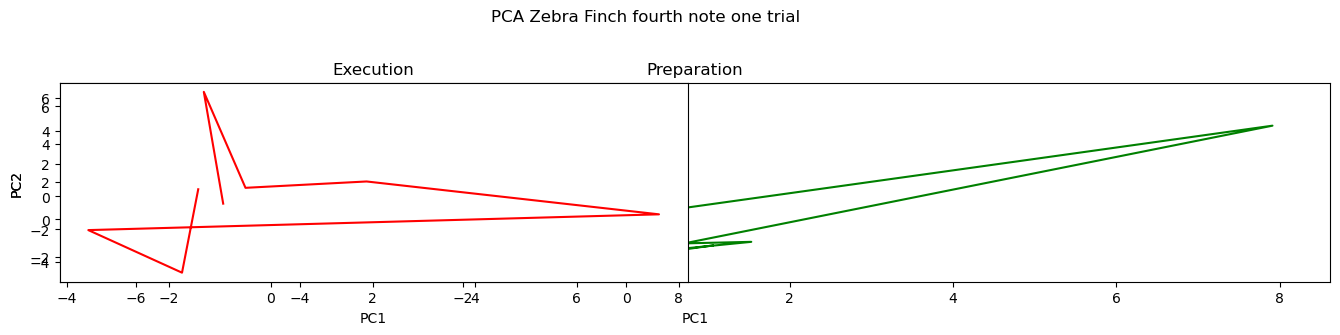

In [61]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.plot(X_pca[:,0], X_pca[:,1], X_pca[:,2], c='green')
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax1.set_title("Preparation")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.plot(X_pca_ex[:,0], X_pca_ex[:,1], X_pca_ex[:,2], c='red')
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
ax2.set_title("Execution")

fig.suptitle("PCA Zebra Finch")
plt.tight_layout()
plt.show()

In [90]:
#human attempted speech

import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

facial = sio.loadmat('t12.2022.05.03_fiftyWordSet.mat')

tx2 = facial['tx2']
spikepow = facial['spikePow']
delay_epochs = facial['delayTrialEpochs']
go_epochs = facial['goTrialEpochs']
prep_data = []
exec_data = []

cuelist = facial['cueList'][0]
trialcues = facial['trialCues']
cue_list = [c[0] for c in cuelist]
cue_list

target_word = 'hungry'
target_index = cue_list.index(target_word)
target_trials = np.where(trialcues == target_index)[0]

print(target_index)
print(target_trials)

prep_data = []
exec_data = []

trial = target_trials[0]
start, end = delay_epochs[trial]
prep_data = tx2[start:end, :]

start_end = go_epochs[trial]
exec_data = tx2[start:end, :]

prep_matrix = np.vstack(prep_data)
exec_matrix = np.vstack(exec_data)

scaler = StandardScaler()

prep_scaled = scaler.fit_transform(prep_matrix)
exec_scaled = scaler.fit_transform(exec_matrix)

prep_pca_human = pca.fit_transform(prep_scaled)
exec_pca_human = pca.fit_transform(exec_scaled)


24
[ 40  48 165 183 220 285 317 342 447 479 525 595 644 677 715 797 852 884
 960 998]


In [91]:
human_prep = prep_pca_human[:, :5]
human_exec = exec_pca_human[:, :5]
bird_prep = X_pca[:, :5]
bird_exec = X_pca_ex[:, :5]

bird_prep_mean = bird_prep.mean(axis=0)
bird_exec_mean = bird_exec.mean(axis=0)
human_prep_mean = human_prep.mean(axis=0)
human_exec_mean = human_exec.mean(axis=0)

In [92]:
pair_prep = np.vstack([bird_prep_mean, human_prep_mean])

labels = ['bird prep', 'human prep']

corr_matrix_prep = np.corrcoef(pair_prep)
corr_prep_df = pd.DataFrame(corr_matrix_prep, index=labels, columns=labels)
print(corr_prep_df)

            bird prep  human prep
bird prep    1.000000    0.883635
human prep   0.883635    1.000000


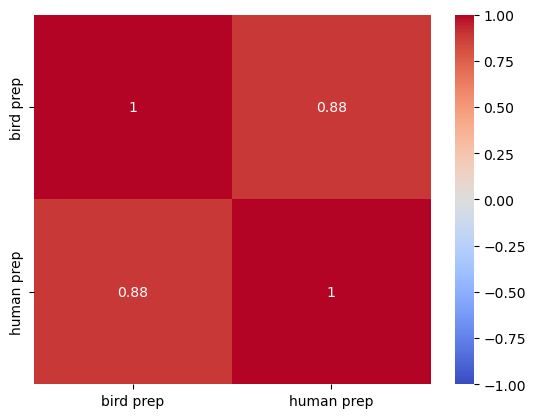

In [93]:
import seaborn as sns
sns.heatmap(corr_prep_df, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.show()

In [94]:
pair_exec = np.vstack([bird_exec_mean, human_exec_mean])

labels = ['bird exec', 'human exec']

corr_matrix_exec = np.corrcoef(pair_exec)
corr_exec_df = pd.DataFrame(corr_matrix_exec, index=labels, columns=labels)
print(corr_exec_df)

            bird exec  human exec
bird exec    1.000000    0.306473
human exec   0.306473    1.000000


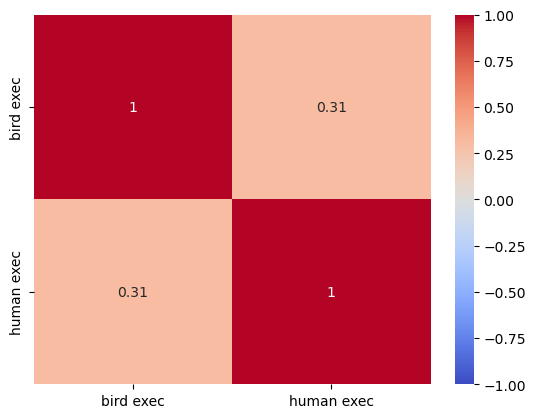

In [95]:
import seaborn as sns
sns.heatmap(corr_exec_df, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.show()